In [1]:
from CL_Split import train_df as data
from UTILS import *
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor 
import seaborn as sns
from joblib import dump
import time

In [2]:
data['Order Date']=pd.to_datetime(data['Order Date'])
data['Order year']=data['Order Date'].dt.year
data['Order quarter']=data['Order Date'].dt.quarter
data = data.drop('Order Date', axis=1)
data['Ship Date']=pd.to_datetime(data['Ship Date'])
data['Ship year']=data['Ship Date'].dt.year
data['Ship quarter']=data['Ship Date'].dt.quarter
data = data.drop('Ship Date', axis=1)
#Extract Categories
data[["Main Category","Sub Category"]]=data["CategoryTree"].str.extract("'MainCategory': '(?P<Main_Category>[^']*)', 'SubCategory': '(?P<Sub_Category>[^']*)'")
data.drop(columns=['CategoryTree'],inplace=True)
#Drop Features
data.drop(columns=["Row ID","Order ID","Customer ID","City","Postal Code","Ship year","Ship quarter","Product Name","Country","Segment"],inplace=True)


In [3]:
time_map={"Validation":{},"fit":{}}

In [4]:
transform_target={"High Loss":0,"Low Loss":1,"Low Profit":2,"Medium Profit":3,"High Profit":4}
data["ReturnCategoryNominal"]=data["ReturnCategory"].map(transform_target)


In [5]:
data["ReturnCategoryNominal"]

1467    3
6071    3
2337    3
1578    2
6522    3
       ..
5226    3
5390    3
860     3
7603    2
7270    4
Name: ReturnCategoryNominal, Length: 6396, dtype: int64

In [6]:
data=remove_outliers(data,["Sales"],threshold=2.5)

In [7]:
mapping_dict=transform_ordinal(data,"State","ReturnCategoryNominal")
data['state_mean'] = data['State'].map(mapping_dict)

In [8]:
sub_cat_dict=transform_ordinal(data,"Sub Category","ReturnCategoryNominal")

In [9]:
data["sub_cat_encoded"]=data["Sub Category"].map(sub_cat_dict)

In [10]:
final_df_cat,onehot_scaler=one_hot_encode_columns(["Main Category","Region"],data)

d:\FCIS\Machine Learning\Project\Environ\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
final_df_num=feature_select_numerical(filter_numerical(data),"ReturnCategoryNominal")

In [12]:
final_df=pd.concat([final_df_num,final_df_cat],axis=1)

In [13]:
final_df_norm,scaler=normalize_feature(final_df.drop(columns=["ReturnCategoryNominal"]))

In [14]:
final_df_norm

,Sales,Quantity,Discount,state_mean,sub_cat_encoded,Main Category_Furniture,Main Category_Office Supplies,Main Category_Technology,Region_Central,Region_East,Region_South,Region_West
1467,0.057885,0.153846,0.250,0.354167,0.1250,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6071,0.122880,0.000000,0.000,0.333333,0.6875,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2337,0.239768,0.230769,0.000,0.270833,0.5625,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1578,0.023335,0.076923,0.000,0.645833,0.5000,1.0,0.0,0.0,0.0,1.0,0.0,0.0
6522,0.026158,0.307692,0.000,0.395833,0.7500,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5226,0.024104,0.384615,0.250,0.333333,0.1250,0.0,1.0,0.0,0.0,1.0,0.0,0.0
5390,0.046046,0.307692,0.000,0.270833,0.8125,0.0,1.0,0.0,0.0,0.0,0.0,1.0
860,0.047307,0.000000,0.000,0.770833,0.6875,0.0,1.0,0.0,0.0,0.0,1.0,0.0
7603,0.026642,0.076923,0.250,0.145833,0.5000,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
final_df_norm["ReturnCategoryNominal"]=final_df["ReturnCategoryNominal"]

In [16]:
X=final_df_norm.drop(columns=["ReturnCategoryNominal"])
y=final_df_norm["ReturnCategoryNominal"]


<h3>SVM</h3
>

In [17]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
classifier = SVC()

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
}
start=time.time()
grid_search_svm = GridSearchCV(classifier, param_grid, cv=5)
grid_search_svm.fit(X, y)
time_map["Validation"]["svm"]=time.time()-start

best_model = grid_search_svm.best_estimator_
print(f'Best Model {best_model}')
print(f'Best Score {grid_search_svm.best_score_}')

Best Model SVC(C=10, kernel='poly')
Best Score 0.7852461440784927


<h3>Logistic Regression</h3>

In [18]:
from sklearn.linear_model import LogisticRegression
classifier=LogisticRegression(max_iter=100000)

param_grid={
    'C': [0.1, 1, 10],
    'solver':['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky','saga']
}
start=time.time()
grid_search_lgreg=GridSearchCV(classifier,param_grid,cv=5)
grid_search_lgreg.fit(X,y)
time_map["Validation"]["lgreg"]=time.time()-start
print(f'Best Model {grid_search_lgreg.best_estimator_}')
print(f'Best Score {grid_search_lgreg.best_score_}')

Best Model LogisticRegression(C=10, max_iter=100000)
Best Score 0.7408600190214412


<h3>Decision Tree</h3>

In [19]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
start=time.time()
grid_search_dt = GridSearchCV(classifier, param_grid, cv=5)
grid_search_dt.fit(X, y)
time_map["Validation"]["tree"]=time.time()-start
print("Best Model:", grid_search_dt.best_estimator_)
print("Accuracy score:", grid_search_dt.best_score_)


Best Model: DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=4,
                       min_samples_split=10)
Accuracy score: 0.8492712697194464


<h3>Random Forest</h3>

In [20]:
from sklearn.ensemble import RandomForestClassifier
classifier=DecisionTreeClassifier()
param_grid = {
    'criterion':['gini','entropy','log_loss'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
start=time.time()
grid_search_rf=GridSearchCV(classifier,param_grid,cv=5)
grid_search_rf.fit(X,y)
time_map["Validation"]["rf"]=time.time()-start
print("Best Model:", grid_search_rf.best_estimator_)
print("Accuracy score:", grid_search_rf.best_score_)


Best Model: DecisionTreeClassifier(criterion='log_loss', min_samples_split=10)
Accuracy score: 0.8451205923674555


In [21]:
start=time.time()
svc=SVC(**(grid_search_svm.best_params_)).fit(X,y)
time_map["fit"]["svm"]=time.time()-start
start=time.time()
lgreg=LogisticRegression(**(grid_search_lgreg.best_params_),max_iter=10000).fit(X,y)
time_map["fit"]["lgreg"]=time.time()-start
start=time.time()
tree=DecisionTreeClassifier(**(grid_search_dt.best_params_)).fit(X,y)
time_map["fit"]["tree"]=time.time()-start
start=time.time()
rf=RandomForestClassifier(**(grid_search_rf.best_params_)).fit(X,y)
time_map["fit"]["rf"]=time.time()-start

In [27]:
missing_values = pd.read_csv('Missing_values_-_classification.csv')
arr = missing_values['Value'].to_numpy()

In [28]:
from joblib import dump
Model={"Model":{"svc":svc,"lgreg":lgreg,"tree":tree,"rf":rf},"Scaler":scaler,"Onehot_scaler":onehot_scaler}
preprocessing={"map_target":transform_target,"map_state":mapping_dict,"map_sub_cat":sub_cat_dict,
               "Columns":filter_numerical(final_df).columns,"missing_values":arr}
dump(Model,"[CL]model_opt1.joblib")
dump(preprocessing,"[CL]preprocessing_opt1.joblib")

['[CL]preprocessing_opt1.joblib']

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, 'Time Taken in Validation')

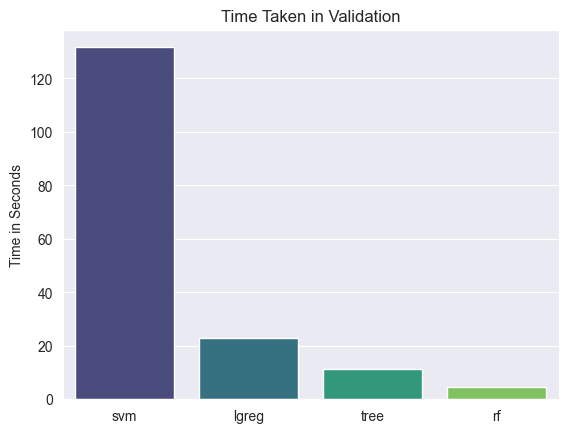

In [25]:
plt.figure()
sns.set_style("darkgrid")
plt.rcParams["figure.facecolor"] = "gray"

sns.barplot(x=list(time_map["Validation"].keys()),y=list(time_map["Validation"].values()),palette="viridis")
plt.ylabel("Time in Seconds")
plt.title("Time Taken in Validation")

Text(0.5, 1.0, 'Time Taken in Fit')

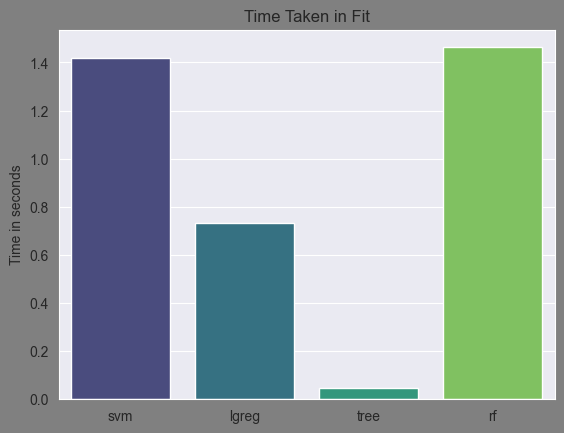

In [26]:
plt.figure()
sns.set_style("darkgrid")
plt.rcParams["figure.facecolor"] = "gray"

sns.barplot(x=list(time_map["fit"].keys()),y=list(time_map["fit"].values()),palette="viridis")
plt.ylabel("Time in seconds")
plt.title("Time Taken in Fit")